In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# imports
import numpy as np
import pandas as pd

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

from sklearn.feature_selection import SelectKBest, chi2

In [3]:
#load the data
df=pd.read_csv("/content/drive/MyDrive/ai4i2020.csv", engine='python', encoding='UTF-8')

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [7]:
def build_categorical_features_report(data_df):

    """Build tabular report for categorical features"""

    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list())

    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())

    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[cat_feat_names]

    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

build_categorical_features_report(df)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
Product ID,10000,0.0,10000,"[H29424, H29425, H29432, H29434, H29441, H2945...",10000,100.0,[],0,0.00
Type,10000,0.0,3,[L],6000,60.0,[M],2997,29.97


In [8]:
def build_continuous_features_report(data_df):

    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

build_continuous_features_report(df)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
UDI,10000,0.0,10000,1.0,2500.75,5000.50000,5000.5,7500.25,10000.0,2886.895680
Air temperature [K],10000,0.0,93,295.3,298.30,300.00493,300.1,301.50,304.5,2.000259
Process temperature [K],10000,0.0,82,305.7,308.80,310.00556,310.1,311.10,313.8,1.483734
Rotational speed [rpm],10000,0.0,941,1168.0,1423.00,1538.77610,1503.0,1612.00,2886.0,179.284096
Torque [Nm],10000,0.0,577,3.8,33.20,39.98691,40.1,46.80,76.6,9.968934
Tool wear [min],10000,0.0,246,0.0,53.00,107.95100,108.0,162.00,253.0,63.654147
Machine failure,10000,0.0,2,0.0,0.00,0.03390,0.0,0.00,1.0,0.180981
TWF,10000,0.0,2,0.0,0.00,0.00460,0.0,0.00,1.0,0.067671
HDF,10000,0.0,2,0.0,0.00,0.01150,0.0,0.00,1.0,0.106625
PWF,10000,0.0,2,0.0,0.00,0.00950,0.0,0.00,1.0,0.097009


There seems to be no missing data. Dataset is very clean. Next I will try to visualize and see if there are outliers. i will not be considering the values who have just 2 cardinality as they are discrete features.

In [10]:
features_of_interest = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
selected_features = df[features_of_interest]
# Calculate Q1, Q3, and IQR for each feature
Q1 = selected_features.quantile(0.25)
Q3 = selected_features.quantile(0.75)
IQR = Q3 - Q1
IQR

import numpy as np

# Filter the DataFrame to include only numeric columns for IQR calculation
numeric_df = selected_features.select_dtypes(include=[np.number])

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Dictionary to hold the count of outliers for each numeric column
outliers_count = {}

# Initialize an empty set to hold the indices of rows with outliers
outliers_index_set = set()

# Loop through each numeric feature column to find the outliers
for column in numeric_df.columns:
    # Determine the outliers for the column
    outliers = numeric_df[(numeric_df[column] < (Q1[column] - 1.5 * IQR[column])) | (numeric_df[column] > (Q3[column] + 1.5 * IQR[column]))]

    # Store the count of outliers in the dictionary
    outliers_count[column] = len(outliers)

    # Add the indices of the outliers to the set
    outliers_index_set.update(outliers.index)

print("Number of outliers in each numeric feature:")
for column, count in outliers_count.items():
    print(f"{column}: {count}")

Number of outliers in each numeric feature:
Air temperature [K]: 0
Process temperature [K]: 0
Rotational speed [rpm]: 418
Torque [Nm]: 69
Tool wear [min]: 0


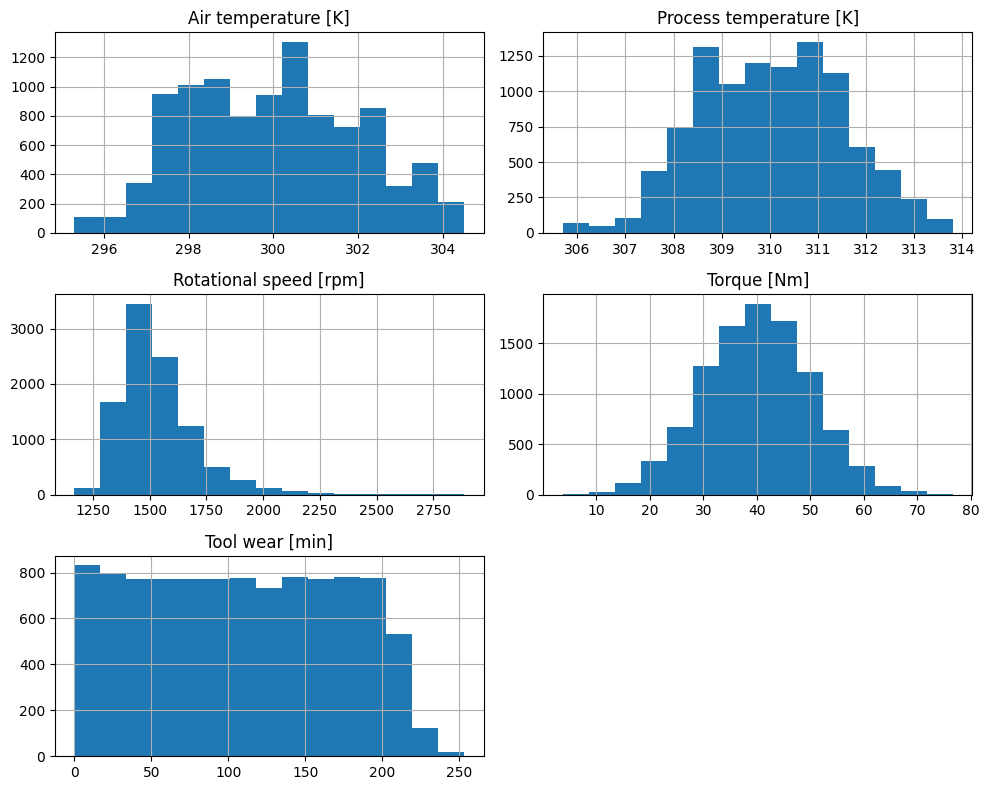

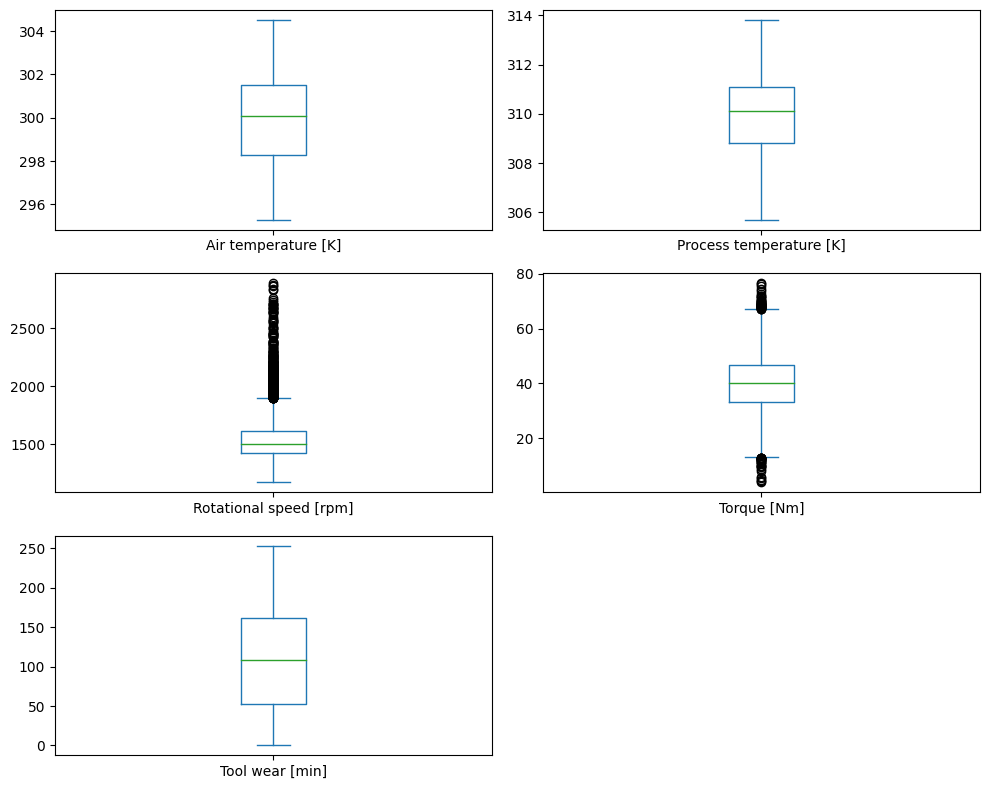

In [11]:
# Plotting histograms
selected_features.hist(figsize=(10, 8), bins=15)
plt.tight_layout()
plt.show()

# Plotting box plots
selected_features.plot(kind='box', subplots=True, layout=(3,2), figsize=(10, 8))
plt.tight_layout()
plt.show()

Rotational speed seems to have a lot of outliers. I think this warrants a bivariate graph of machine failure by other features.

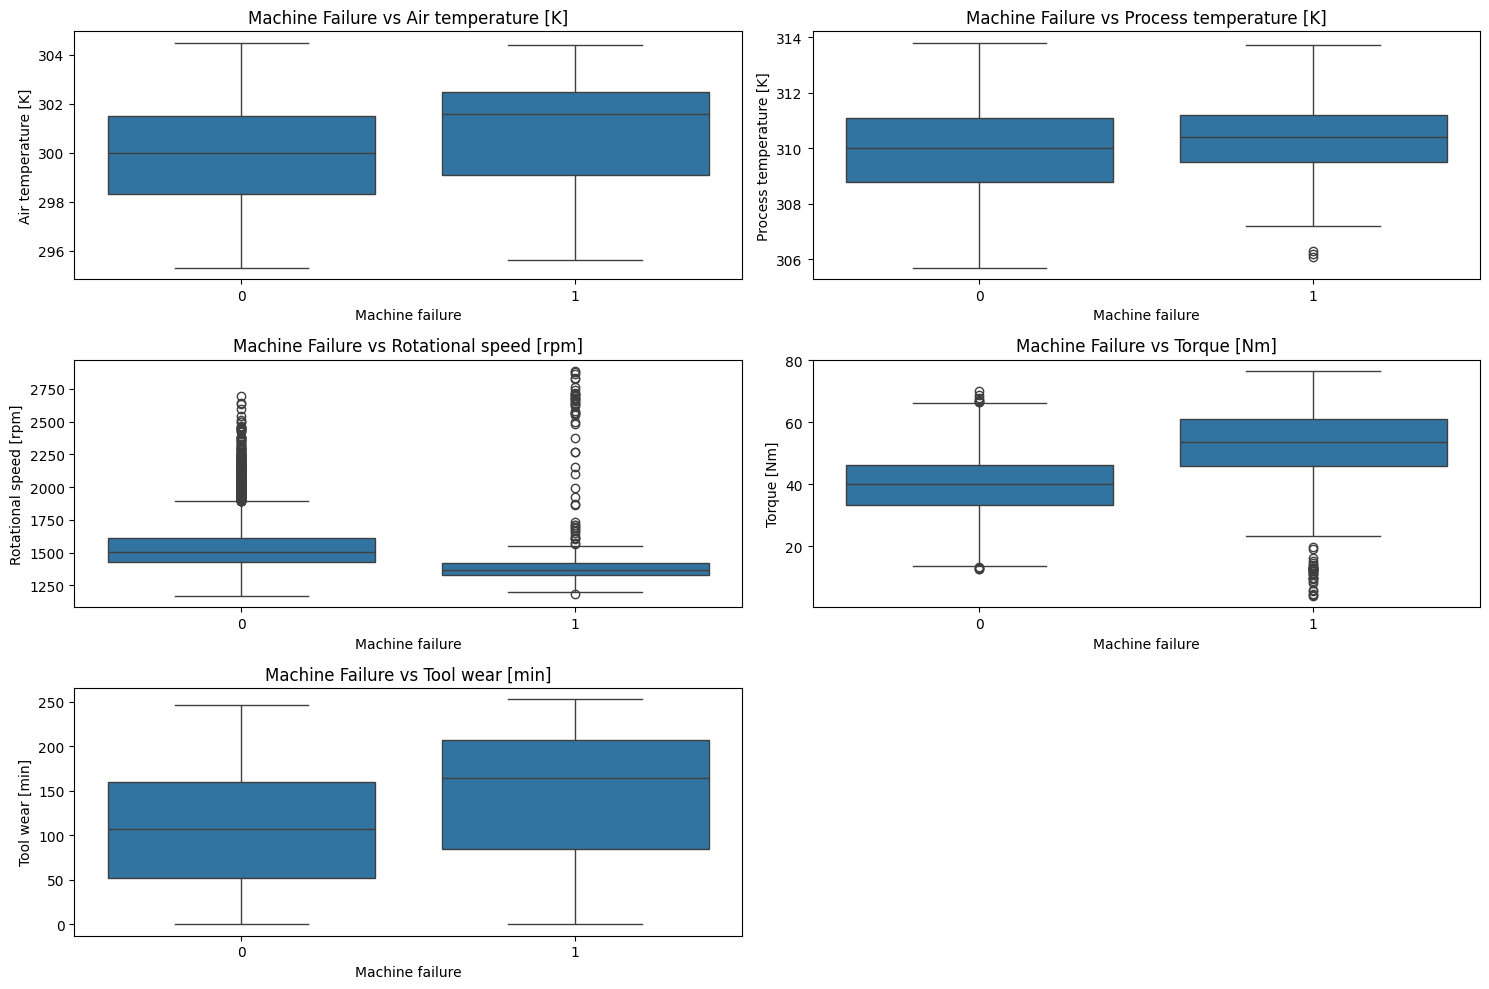

In [12]:

# Redoing the bivariate plots: features vs machine failure
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_of_interest, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Machine failure', y=feature, data=df)
    plt.title(f'Machine Failure vs {feature}')

plt.tight_layout()
plt.show()

From this graph it looks like machines that failed have a lot of outliers in rotational speed. and Outliers indicating low torque might suggest mechanical problems, such as wear and tear in parts that are crucial for maintaining torque. This could include issues with any component that affects the machine's ability to generate or transmit rotational force effectively.

In [13]:
features_of_interest = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure']
df_ = df[features_of_interest]

Correlation Heatmap to see which features correlate with each other and with machine failure

<Axes: >

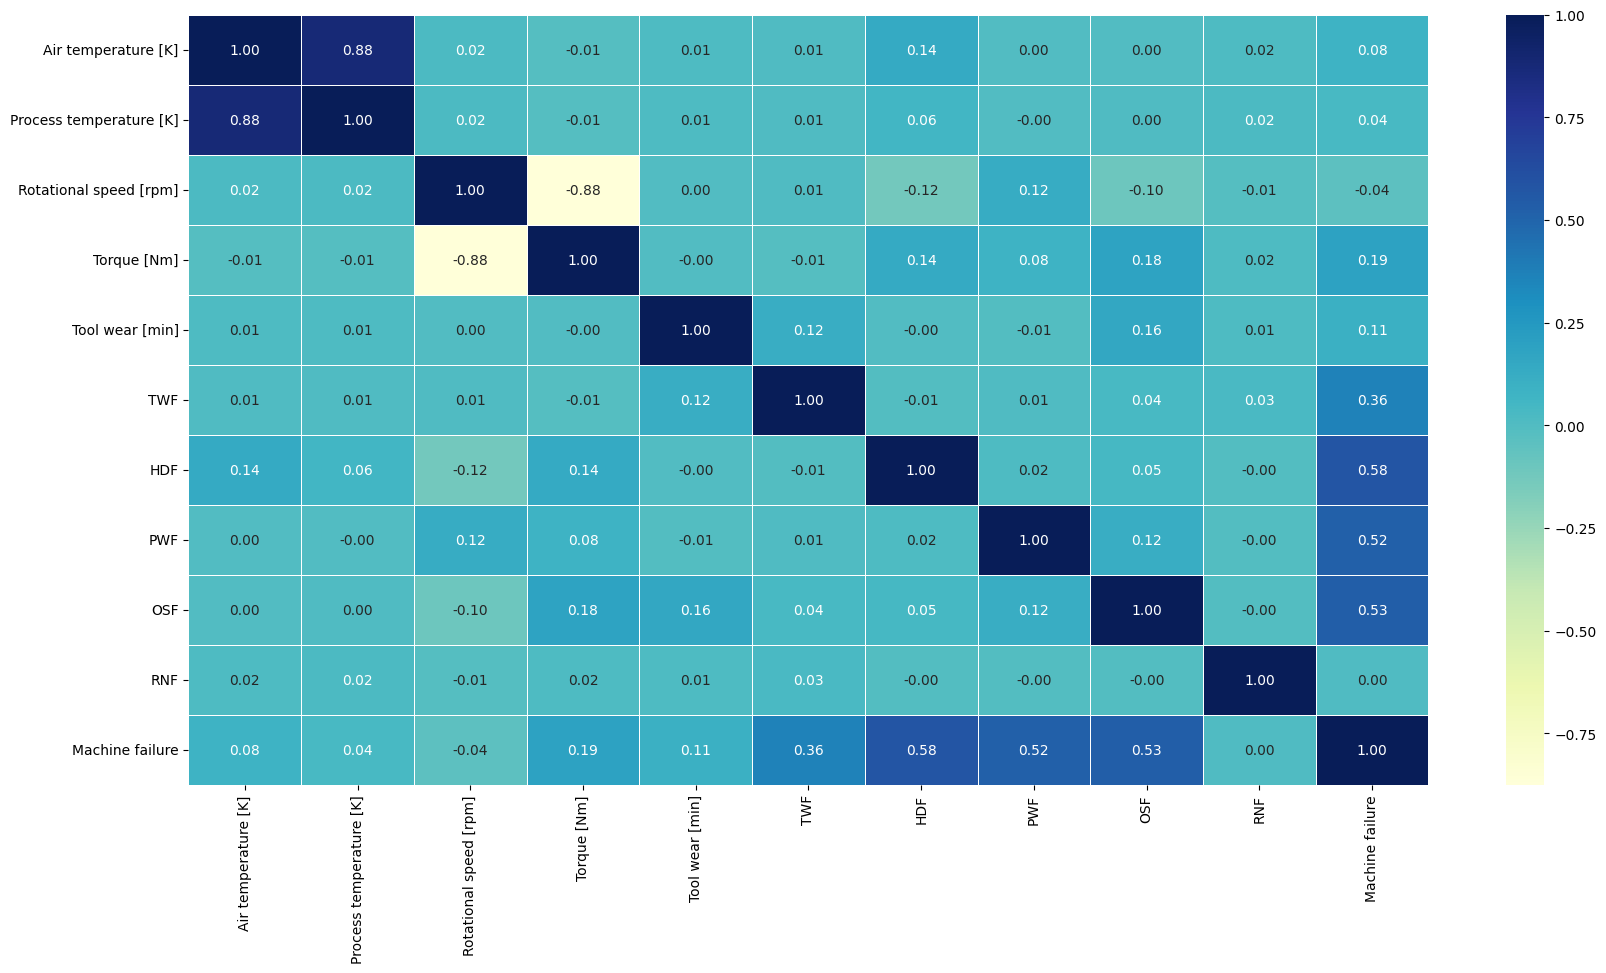

In [15]:
corr_matrix = df_.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")

In [18]:
best_features = SelectKBest(score_func=chi2,k='all')

X = df_.iloc[:,:-1]
y = df_.iloc[:,-1]
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()

From the Chi squared test it looks like Tool wear min, heat dissipation failure, overstrain failure, and power failure are highly predictive of machine failure.

# **Modelling**
I will be using
1. Logistic Regression Classifier
2. Random Forest Classifier
3. XGBoost

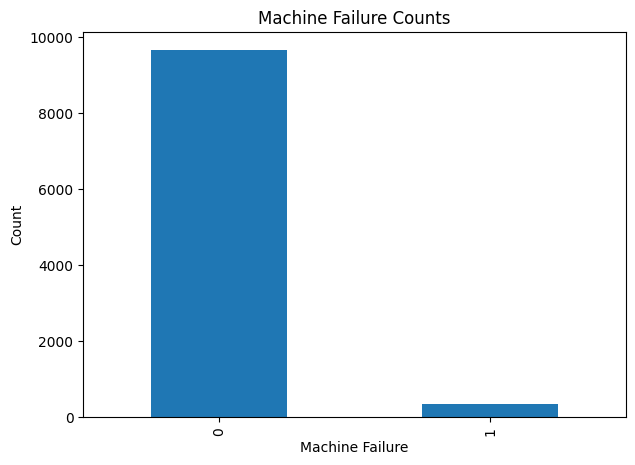

In [22]:
plt.figure(figsize=(7, 5))
df_['Machine failure'].value_counts().plot.bar()
plt.title('Machine Failure Counts')
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.show()

the data is highly imbalanced. One solution here will be to oversample the `1` class.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    stratify=y)


In [26]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
logistic_model = LogisticRegression(random_state=0)
logistic_model.fit(X_train, y_train)
y_preds = logistic_model.predict(X_test)
print("Train accuracy: ", logistic_model.score(X_train, y_train))
print('Test Accuracy: ', logistic_model.score(X_test, y_test))

Train accuracy:  0.999375
Test Accuracy:  0.998


In [37]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.94      0.97        68

    accuracy                           1.00      2000
   macro avg       1.00      0.97      0.98      2000
weighted avg       1.00      1.00      1.00      2000



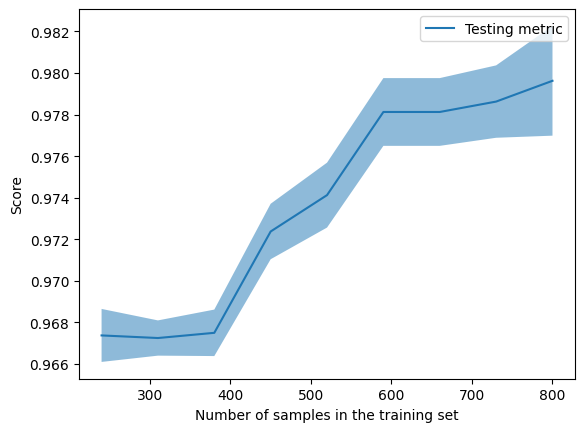

In [41]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
# new_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=6, min_samples_leaf=9)
train_sizes, train_scores, test_scores = learning_curve(logistic_model, X_train, y_train, train_sizes=[ 240, 310, 380, 450, 520, 590, 660, 730, 800])
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

In [42]:
test_scores

array([[0.96625 , 0.9675  , 0.96875 , 0.96875 , 0.965625],
       [0.96625 , 0.9675  , 0.968125, 0.968125, 0.96625 ],
       [0.96625 , 0.9675  , 0.96875 , 0.96875 , 0.96625 ],
       [0.970625, 0.9725  , 0.97125 , 0.974375, 0.973125],
       [0.9725  , 0.97375 , 0.9725  , 0.975625, 0.97625 ],
       [0.9775  , 0.97875 , 0.975625, 0.978125, 0.980625],
       [0.9775  , 0.97875 , 0.975625, 0.978125, 0.980625],
       [0.98    , 0.97875 , 0.975625, 0.978125, 0.980625],
       [0.98375 , 0.97875 , 0.975625, 0.979375, 0.980625]])